# Поиск и классификация товаров народного потребления

**Введение:**

Формирование тенденций потребления товаров у населения — важный аспект для анализа состояния страны. Такая информация может многое рассказать о средней заработной плате на выбранной территории, потребительской способности населения, количестве покупок конкретных товаров.

Вот только у поставщиков не существует общего ГОСТа для заведения позиций товара. Знакомый нам кочан белой капусты может быть записан как: «белокачанная капуста», «капуста белокочанная», «капуст. бел. коч.». Это может создавать ошибки при формировании отчетов и усложнять анализ данных.

**Цель задачи:**

Поиск и классификация конкретных категорий товаров в огромном наборе различных наименований. Необходимо разметить следующие категории:
- Хлебные изделия
- Напитки газированные
- Вода
- Молоко 2.5-3.2 %
- Молочные продукты
- Макароны
- Фрукты
- Продукция общепитов
- Товары без категории

Метрика: Recall

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-обучающих-данных-из-файла" data-toc-modified-id="Изучение-обучающих-данных-из-файла-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение обучающих данных из файла</a></span><ul class="toc-item"><li><span><a href="#Очистка-текста" data-toc-modified-id="Очистка-текста-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Очистка текста</a></span></li><li><span><a href="#Количество-символов-тексте" data-toc-modified-id="Количество-символов-тексте-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Количество символов тексте</a></span></li></ul></li><li><span><a href="#Выделим-признаки" data-toc-modified-id="Выделим-признаки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Выделим признаки</a></span></li><li><span><a href="#Поиск-гиперпараметров" data-toc-modified-id="Поиск-гиперпараметров-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Поиск гиперпараметров</a></span><ul class="toc-item"><li><span><a href="#LinearSVC" data-toc-modified-id="LinearSVC-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearSVC</a></span></li></ul></li><li><span><a href="#Изучение-тестовых-данных-из-файла" data-toc-modified-id="Изучение-тестовых-данных-из-файла-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Изучение тестовых данных из файла</a></span><ul class="toc-item"><li><span><a href="#Количество-символов-тексте" data-toc-modified-id="Количество-символов-тексте-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Количество символов тексте</a></span></li><li><span><a href="#Предсказание-на-тесте" data-toc-modified-id="Предсказание-на-тесте-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Предсказание на тесте</a></span><ul class="toc-item"><li><span><a href="#запись-в-файл" data-toc-modified-id="запись-в-файл-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>запись в файл</a></span></li></ul></li></ul></li></ul></div>

## Изучение обучающих данных из файла

Импортируем библиотеки:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import time
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
warnings.filterwarnings('ignore')

In [3]:
pd.options.display.max_colwidth = 1000
pd.set_option('display.max_columns', 500)

In [4]:
df_train = pd.read_csv('datasets/saratov_train_dataset.csv')

In [5]:
df_train.head(3)

,id,name,groups
0,1034,ШОК-ЦЕНА Пена д/душа/бритья КУППЕР 200 мл АКС,10
1,1035,Мин.вода Нагутская №26 0.5л,0
2,1036,Пельмени Домашние вес ПО Прямицино.,10


- `id` - идентификатор товара
- `name` - описание товара
- `groups` - номер группы товара

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658064 entries, 0 to 658063
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      658064 non-null  int64 
 1   name    658064 non-null  object
 2   groups  658064 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 15.1+ MB


### Очистка текста

Оставим только слова, состоящие из 3 и более символов, и числа из 5 и более цифр c помощью функции `text_clean_func`

In [7]:
def text_clean_func(text):
    text = text.lower()
    text = re.sub(r"ё", "е", text) # замена ё на е
    text = re.sub('(\d+(\.\d+)?)', r' \1 ', text) #пробел между числом и цифрой
    text = re.sub(r"[^\w\d\s]", " ", text)
    text = re.sub(r"' вес ", " ", text)
    shortword = re.compile(r'\W*\b[0-9]{1,4}\b') # удалить числа короче 5 символов
    text = shortword.sub(' ', text)
    shortword = re.compile(r'\W*\b[а-яa-z]{1,2}\b') #удалить слова, состоящие из 1-2 символов
    text = shortword.sub(' ', text)
    text = re.sub("\s+", " ", text)
    text = text.strip(' ')
    return text

In [8]:
%%time
df_train['name_clean'] = df_train['name'].apply(text_clean_func)

CPU times: user 9.74 s, sys: 33.1 ms, total: 9.77 s
Wall time: 9.77 s


In [9]:
df_train[df_train['name'].str.lower().str.contains('7-up') == True]

,id,name,groups,name_clean
60453,61487,"Напиток газированный 7-UP Лимон и лайм, 1,5 л",4,напиток газированный лимон лайм
173630,174664,"Н-к 7-UP 0,33л ж/б",10,
270746,271780,"Напиток б/а сильногазированный ароматизированный 7-Up пэт 2,0л",4,напиток сильногазированный ароматизированный пэт
366687,367721,Напиток б/а 7-UP газ. 1л. пэт,4,напиток газ пэт
464877,465911,Напиток 7-UP Lemon Lemon б/алк,4,напиток lemon lemon алк
465055,466089,Напиток 7-UP 2 л,4,напиток


In [10]:
df_train.head(20)

,id,name,groups,name_clean
0,1034,ШОК-ЦЕНА Пена д/душа/бритья КУППЕР 200 мл АКС,10,шок цена пена душа бритья куппер акс
1,1035,Мин.вода Нагутская №26 0.5л,0,мин вода нагутская
2,1036,Пельмени Домашние вес ПО Прямицино.,10,пельмени домашние вес прямицино
3,1037,ПЕЧЕНЬЕ ОВСЯНО-ГРЕЧНЕВОЕ ЭКО БОТ 4600508719365,10,печенье овсяно гречневое эко бот 4600508719365
4,1038,Спред растительно-жировой Масляничка 62% 170г С ЗМЖ,10,спред растительно жировой масляничка змж
5,1039,4607040961429 ПЕЛЬМЕНИ ЗОЛОТО ДЭМК,10,4607040961429 пельмени золото дэмк
6,1040,2: 3347584 МДБ Колб.ДОКТОР.в/с б/о в/у50,10,3347584 мдб колб доктор
7,1041,Щипцы кухон. 23см пласт.+нерж. сталь ручка VETTA,10,щипцы кухон пласт нерж сталь ручка vetta
8,1042,ИГР.ВИНО ПРОСЕККО НАЦИОНАЛЬ'19 Б 8032770293018,10,игр вино просекко националь 8032770293018
9,1043,"Лапша удон, Курица с овощами, Соус терияки",1,лапша удон курица овощами соус терияки


### Количество символов тексте

Добавим признак с количеством символов в тексте

In [11]:
df_train['length'] = df_train['name_clean'].apply(len)

In [12]:
df_train['length'].describe()

count    658064.000000
mean         29.486273
std          13.274911
min           0.000000
25%          21.000000
50%          28.000000
75%          35.000000
max         126.000000
Name: length, dtype: float64

In [13]:
len(df_train.query('length == 0'))

71

In [14]:
df_train.query('length == 0').sample(10)

,id,name,groups,name_clean,length
320033,321067,"27""",10,,0
66379,67413,"й (ДС-217)""",10,,0
16222,17256,"5 мл (375)""",10,,0
150982,152016,"9561)""",10,,0
33750,34784,"9""",10,,0
113587,114621,".""",10,,0
51903,52937,"50 г""",10,,0
556980,558014,"к 500 мл""",10,,0
195335,196369,"601)""",10,,0
502424,503458,"00 мл""",10,,0


In [15]:
df_train.sort_values(by='length', ascending=False).head()

,id,name,groups,name_clean,length
323597,324631,"Напиток ""ПАУРЕН"" Тропический безалкогольный тонизирующий энергетический газированный пастеризованный без применения консервантов",4,напиток паурен тропический безалкогольный тонизирующий энергетический газированный пастеризованный без применения консервантов,126
199110,200144,Вино защищенного географического указания региона Центральная Долина Текена Каберне Совиньон / Tekena Cabernet Sauvignon красное,10,вино защищенного географического указания региона центральная долина текена каберне совиньон tekena cabernet sauvignon красное,126
238851,239885,"БЭЛЛА НАЙТ Супертонкие женские гигиенические впитывающие прокладки для критических дней ""bella Perfecta ultra violet deo fresh""",10,бэлла найт супертонкие женские гигиенические впитывающие прокладки для критических дней bella perfecta ultra violet deo fresh,125
651620,652654,"ягодный микс.Напиток безалкогольный тонизирующий(энергетический)газированный витаминизированный ароматизированный""Флеш Ап Энерги",4,ягодный микс напиток безалкогольный тонизирующий энергетический газированный витаминизированный ароматизированный флеш энерги,125
7922,8956,"Трусы впитывающие для взрослых для средней и тяжёлой степени недержания под товарным знаком seni, вариант исполнения: seni ACTIV",10,трусы впитывающие для взрослых для средней тяжелой степени недержания под товарным знаком seni вариант исполнения seni activ,124


In [16]:
df_train.query('length != 0').sort_values(by='length', ascending=True).head(10)

,id,name,groups,name_clean,length
340456,341490,"Сок, шт.",10,сок,3
355443,356477,"БАД ж/б 0,45л 5%",10,бад,3
176167,177201,ЙОД 5% 25МЛ,10,йод,3
215610,216644,"Сок 0,200 л.",10,сок,3
244039,245073,LED 16-125W Е27 ГР,10,led,3
427946,428980,Т: Но-Шпа (0.5 мл) (1 x 50),10,шпа,3
591815,592849,КР Д/Л ЧЛ МОР ОТ 55Л,10,мор,3
436815,437849,СОК 200 гр. в ас-те,10,сок,3
494126,495160,"Йод,сп.р-р,5%,10мл =Ц.35р.",10,йод,3
657963,658997,ХЛ. В/С БОЛ,1,бол,3


Посмотрим на группы товаров с 0 длинной описания

In [17]:
df_train.query('length == 0')['groups'].value_counts()

10    70
3      1
Name: groups, dtype: int64

Посмотрим на распределение длинны текста в наших данных

In [18]:
def histplot_boxplot(df, column, bins=127):
    """
    df - датафрейм
    column - название признака для построения графиков
    bins - количество корзин (50 по умолчанию)
    
    """
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.13, .87)},
                                        figsize=(10, 5))
    sns.boxplot(data=df, 
                x=column,  
                orient='h',
                order=[1,0],
                palette='pastel',
                ax=ax_box)
    sns.histplot(data=df, 
                 x=column, 
                 bins=bins, 
                 kde=True, 
                 palette='pastel', 
                 hue_order=[1,0],
                 ax=ax_hist)
 
    ax_box.set(xlabel='')
    ax_box.set(title='Ящик с усами для "{}"'.format(column))
    ax_hist.set(title='Распределение признака "{}"'.format(column))
    plt.show()

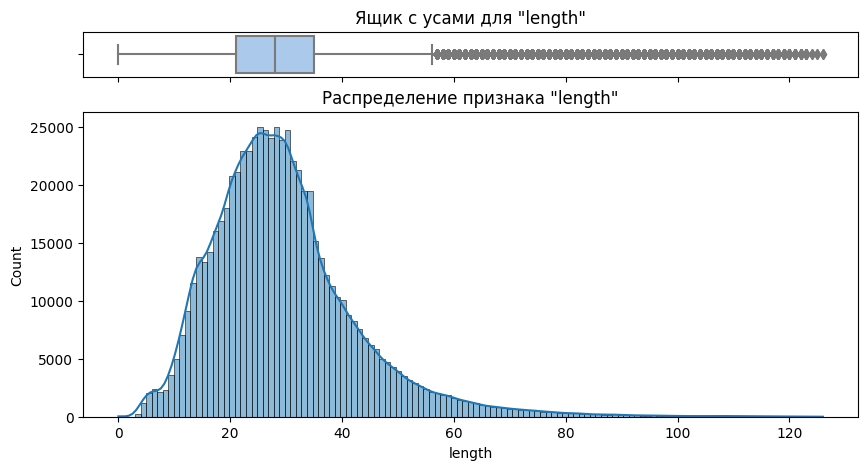

In [19]:
histplot_boxplot(df_train, 'length')

Заполним строки с 0 длинной заглушкой `пусто`

In [20]:
df_train.loc[df_train['length'] == 0, 'name_clean'] = 'пусто'

## Выделим признаки

In [21]:
X_train = df_train['name_clean']

In [22]:
y_train = df_train['groups'].replace({6:5, 7:6, 9:7, 10:8}).values

In [23]:
y_train = y_train.ravel()

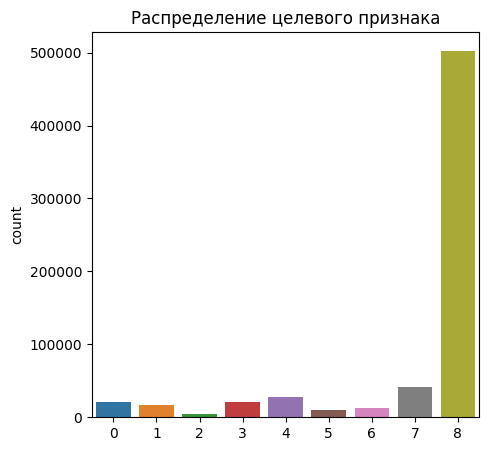

In [24]:
plt.figure(figsize=(5,5))
sns.countplot(x=y_train).set_title('Распределение целевого признака')
plt.show()

## Поиск гиперпараметров

Зафиксируем параметр псевдослучайности для наших моделей и выборок:

In [25]:
rnd_st = 12345

Напишем функцию `grid_search_func` для проведения поиска по решетке, вывода лучших гиперпараметров модели и метрики. Функция будет возвращать лучший оценщик

In [26]:
recall = make_scorer(recall_score , average='macro')

In [27]:
def grid_search_func(model, parameters, features_train, target_train):
    """
    model - модель
    param_grid - параметры для поиска по решетке
    features_train - входные признаки обучающая выборка
    target_train - входные признаки тестовая выборка
    
    """
    gs = GridSearchCV(estimator=model, param_grid=parameters, 
                      scoring=recall, cv=2, verbose=0)
    gs.fit(features_train, target_train)
    gs_best_estimator = gs.best_estimator_
    print('Best parameters:', gs.best_params_)
    print('Best recall = %.4f' % abs(gs.best_score_))
    return gs_best_estimator

### LinearSVC

In [28]:
svc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=2,
                              sublinear_tf=True,
                              use_idf=False,
                              ngram_range=(1,2))),
    ('logreg', LinearSVC(random_state=rnd_st,
                         tol=0.001,
                         class_weight='balanced',
                         max_iter=1_000_000,
                         multi_class='crammer_singer'))
])
param_grid = {
    'logreg__C': [0.27],
#     'logreg__C': [0.24,0.27,0.30],
}

In [29]:
%%time
svc_pipe_best_estimator = grid_search_func(svc_pipe, param_grid, X_train, y_train)

Best parameters: {'logreg__C': 0.27}
Best recall = 0.9700
CPU times: user 1min 31s, sys: 539 ms, total: 1min 31s
Wall time: 1min 31s


## Изучение тестовых данных из файла

Загрузим тестовые данные в `df_test`, а данные для отправки в `df_sample_solution`

In [30]:
df_test = pd.read_csv('datasets/saratov_test_dataset.csv')
df_sample_solution = pd.read_csv('datasets/sample_solution.csv')

In [31]:
print(df_test.shape, df_sample_solution.shape)

(282227, 2) (282227, 2)


In [32]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282227 entries, 0 to 282226
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      282227 non-null  int64 
 1   name    282227 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.3+ MB


In [33]:
df_test.head()

,id,name
0,10529,"КАРАМЕЛЬ ""ЛАКОМКА-СУПЕРМОЛОЧНАЯ"" ВЕС (РОТ ФРОНТ)"
1,10530,"2: 3637233 РАЭ Масло ТРАДИЦ.слив.82,5% 1"
2,10531,960012-LG NS Бинт эластичный Classic лаймовый р. NS
3,10532,Вода мин. 1.5л пл/у (Сахалинская)
4,10533,Ролики натяжителя ремня AMD.GTA0740 AMD


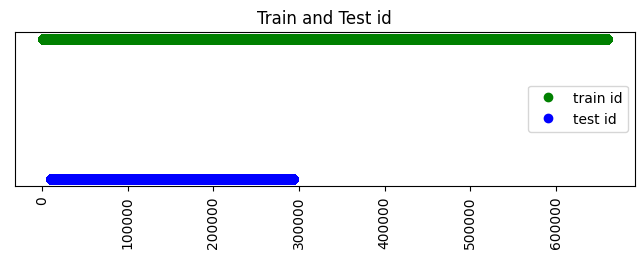

In [34]:
plt.figure(figsize=(8, 2))
plt.plot(df_train['id'], np.ones(df_train.shape[0]), 'o', c='green', label='train id')
plt.plot(df_test['id'], np.zeros(df_test.shape[0]), 'o', c='blue', label='test id')
plt.title('Train and Test id')
plt.yticks([])
plt.xticks(rotation=90)
plt.legend( loc='center right')
plt.show()

Провем те же манипуляции с тестовыми данными, что и на обучающей выборке с помощью функции `text_clean_func`

In [35]:
%%time
df_test['name_clean'] = df_test['name'].apply(text_clean_func)

CPU times: user 4.31 s, sys: 15 ms, total: 4.33 s
Wall time: 4.33 s


In [36]:
df_test.head()

,id,name,name_clean
0,10529,"КАРАМЕЛЬ ""ЛАКОМКА-СУПЕРМОЛОЧНАЯ"" ВЕС (РОТ ФРОНТ)",карамель лакомка супермолочная вес рот фронт
1,10530,"2: 3637233 РАЭ Масло ТРАДИЦ.слив.82,5% 1",3637233 раэ масло традиц слив
2,10531,960012-LG NS Бинт эластичный Classic лаймовый р. NS,960012 бинт эластичный classic лаймовый
3,10532,Вода мин. 1.5л пл/у (Сахалинская),вода мин сахалинская
4,10533,Ролики натяжителя ремня AMD.GTA0740 AMD,ролики натяжителя ремня amd gta amd


### Количество символов тексте

Добавим признак с количеством символов в тексте

In [37]:
df_test['length'] = df_test['name_clean'].apply(len)

Посмотрим на группы товаров с 0 длинной описания

In [38]:
len(df_test.query('length == 0'))

32

In [39]:
df_test.query('length == 0').head()

,id,name,name_clean,length
13481,24010,"85 г""",,0
16086,26615,"5)""",,0
16254,26783,1,,0
30183,40712,"ИЯ/уп.""",,0
50145,60674,"90х60 N30/шт""",,0


Посмотрим на распределение длинны текста в наших данных

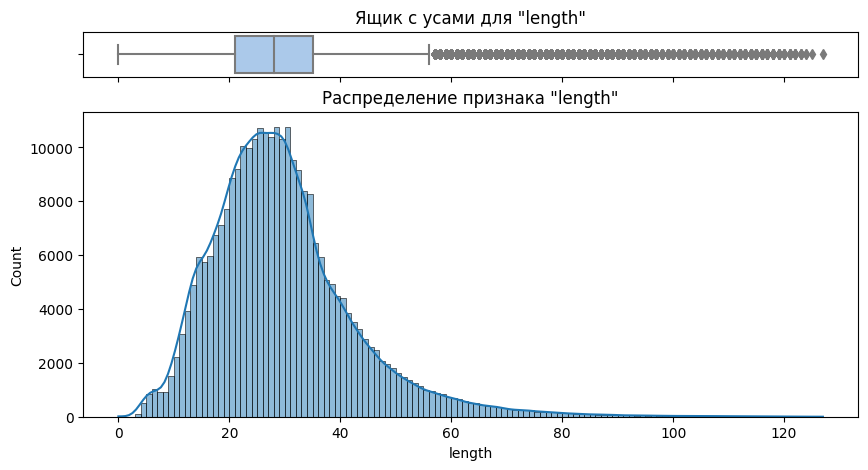

In [40]:
histplot_boxplot(df_test, 'length')

Заполним строки с 0 длинной заглушкой `пусто`

In [41]:
df_test.loc[df_test['length'] == 0, 'name_clean'] = 'пусто'

Выделим тестовую выборку

In [42]:
X_test = df_test['name_clean']

### Предсказание на тесте

In [43]:
y_pred = pd.Series(svc_pipe_best_estimator.predict(X_test)).replace({8:10, 7:9, 6:7, 5:6})
y_pred.value_counts()

10    206590
9      18284
4      12153
1      10293
0       9423
3       9139
6       7874
7       6665
2       1806
dtype: int64

#### запись в файл

In [44]:
df_sample_solution['groups'] = y_pred
df_sample_solution['id'] = df_test['id']
df_sample_solution.to_csv("datasets/sample_solution.csv", index=False)